https://fakeddit.netlify.app

In [3]:
import pandas as pd
import requests
import urllib.parse
import os
from PIL import Image
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

from dataProcess_util import *

In [2]:
df = pd.read_csv('fakeddit/multimodal_train.tsv', sep='\t')

print(f"Dataset: {df.shape}")
print(f"\nrow: {df.columns}")
print(f"\nfirst 5 rows:")
df.head()

Dataset: (564000, 16)

row: Index(['author', 'clean_title', 'created_utc', 'domain', 'hasImage', 'id',
       'image_url', 'linked_submission_id', 'num_comments', 'score',
       'subreddit', 'title', 'upvote_ratio', '2_way_label', '3_way_label',
       '6_way_label'],
      dtype='object')

first 5 rows:


,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


test URL: https://external-preview.redd.it/WylDbZrnbvZdBpgfa3ntxYf17CBHndiJWHylVm2j_nY.jpg?width=320&crop=smart&auto=webp&s=449659a10792de4d55c2f27d2176fdc8bc66e72a
real URL: https://external-preview.redd.it/WylDbZrnbvZdBpgfa3ntxYf17CBHndiJWHylVm2j_nY.jpg?width=320&crop=smart&auto=webp&s=449659a10792de4d55c2f27d2176fdc8bc66e72a
✓
image size: (320, 426)


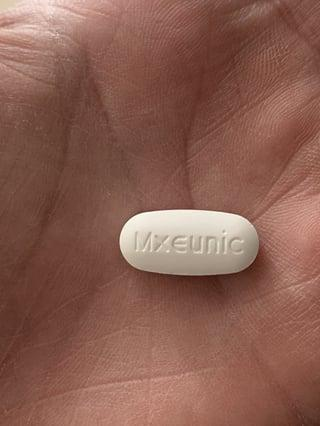

In [ ]:
# Test the improved image downloading function
test_url = df.iloc[0]['image_url']
print(f"test URL: {test_url}")
print(f"real URL: {extract_actual_url(test_url)}")

result = download_image_improved(test_url, 'fakeddit/test_improved.jpg')
if result:
    print("✓")
    img = Image.open('fakeddit/test_improved.jpg')
    print(f"image size: {img.size}")
    display(img)

In [11]:
# 1. Sample more than needed
sampled_df = df.sample(n=12000, random_state=42).reset_index(drop=True)

In [ ]:
# 2. Download images with Error Handling and Parallelism
successful_count, failed_df = download_images_batch_improved(
    sampled_df, 
    'train_images',
    num_workers=10  
)

In [20]:
# Get list of downloaded images
import os

downloaded_images = set(os.listdir('train_images'))
print(f"Total images in train_images: {len(downloaded_images)}")

# Filter sampled_df to keep only rows with corresponding images
# Images are named using the 'id' field, not 'linked_submission_id'
def has_image(row):
    image_name = f"{row['id']}.jpg"
    return image_name in downloaded_images

sampled_df_filtered = sampled_df[sampled_df.apply(has_image, axis=1)].reset_index(drop=True)
print(f"Rows with images: {len(sampled_df_filtered)}")

# Save to CSV
sampled_df_filtered.to_csv('train_sampled_with_images.csv', index=False)
print(f"Saved to train_sampled_with_images.csv")

Total images in train_images: 10735
Rows with images: 10735
Saved to train_sampled_with_images.csv
